# Histogram

hist provides two types of histograms, in which Hist is the general class, NamedHist is a forced-name class. hist supports the whole workflow for a histogram's lifecycle, including some plotting tools and shortcuts which are pretty useful for HEP studies. Here, you can see how to serialize/deserialize (will be achieved), construct, use, and visualize histograms.

![histogram's lifecycle](https://tva1.sinaimg.cn/large/007S8ZIlgy1ggrgi6xk7fj30y108qjsf.jpg)

## Hist

Hist is the general class in the hist package based on [boost-histogram](https://github.com/scikit-hep/boost-histogram)'s Histogram. Here is how to serialize/deserialize (will be achieved), construct, use, and visualize histograms via Hist.

### Initialize Hist

You need to initialized Hist first before you use it. Two ways are provided: you can just fill the axes into the Hist instance and create it; you can also add axes in Hist object via hist proxy. 

When initializing you don't have to use named-axes, axes without names are allowed. Using named-axes is recommended, because you will get more shortcuts to make the best of hist (there is also a classed called NamedHist which forces names be used most places). Duplicated non-empty names are not allowed in the Hist as name is the unique indentifier for a Hist object.

In [1]:
from hist import Hist
import hist

#### Standard method:

In [2]:
# fill the axes
h = Hist(
    hist.axis.Regular(
        50, -5, 5, name="S", label="s [units]", underflow=False, overflow=False
    ),
    hist.axis.Regular(
        50, -5, 5, name="W", label="w [units]", underflow=False, overflow=False
    ),
)

#### Shortcut method:

One benefit of the shortcut method is that you can work entirely from Hist, so `from hist import Hist` can be used.

In [3]:
# add the axes, finalize with storage
h = (
    Hist.new.Reg(50, -5, 5, name="S", label="s [units]", flow=False)
    .Reg(50, -5, 5, name="W", label="w [units]", flow=False)
    .Double()
)

### Manipulate Hist

#### Fill Hist

After initializing the Hist, the most likely thing you want to do is to fill it. The normal method to fill the histogram is just to pass the data to `.fill()`, and the data will be filled in the index order. If you have axes all with names in your Hist, you will have another option -- filling by names in the order of names given.

In [4]:
import numpy as np

s_data = np.random.normal(size=50_000)
w_data = np.random.normal(size=50_000)

# normal fill
h.fill(s_data, w_data)

# Clear the data since we want to fill again with the same data
h.reset()

# fill by names
h.fill(W=w_data, S=s_data)

Hist(
  Regular(50, -5, 5, name='S', label='s [units]'),
  Regular(50, -5, 5, name='W', label='w [units]'),
  storage=Double()) # Sum: 50000.0

#### Access Bins

hist allows you to access the bins of your Hist by various ways. Besides the normal access by index, you can use locations (supported by boost-histogram), complex numbers, and the dictionary to access the bins.

In [5]:
# Access by bin number
h[25, 25]

291.0

In [6]:
# Access by data coordinate
# Identical to: h[hist.loc(0), hist.loc(0)]
h[0j, 0j]

291.0

In [7]:
# Identical to: h[hist.loc(-1) + 5, hist.loc(-4) + 20]
h[-1j + 5, -4j + 20]

291.0

If you are accessing multiple bins, you can use complex numbers to rebin.

In [8]:
# Identical to: h.project("S")[20 : 30 : hist.rebin(2)]
h.project("S")[20:30:2j]

Hist(Regular(5, -1, 1, name='S', label='s [units]'), storage=Double()) # Sum: 34136.0 (50000.0 with flow)

Dictionary is allowed when accessing bins. If you have axes all with names in your Hist, you can also access them according to the axes' names.

In [9]:
s = Hist(
    hist.axis.Regular(50, -5, 5, name="Norm", label="normal distribution"),
    hist.axis.Regular(50, 0, 1, name="Unif", label="uniform distribution"),
    hist.axis.StrCategory(["hi", "hello"], name="Greet"),
    hist.axis.Boolean(name="Yes"),
    hist.axis.Integer(0, 1000, name="Int"),
)

In [10]:
s.fill(
    Norm=np.random.normal(size=1000),
    Unif=np.random.uniform(size=1000),
    Greet=["hi"] * 800 + ["hello"] * 200,
    Yes=[True] * 600 + [False] * 400,
    Int=np.ones(1000),
)

Hist(
  Regular(50, -5, 5, name='Norm', label='normal distribution'),
  Regular(50, 0, 1, name='Unif', label='uniform distribution'),
  StrCategory(['hi', 'hello'], name='Greet', label='Greet'),
  Boolean(name='Yes', label='Yes'),
  Integer(0, 1000, name='Int', label='Int'),
  storage=Double()) # Sum: 1000.0

In [11]:
s[0j, -0j + 2, "hi", True, 1]

3.0

In [12]:
s[{0: 0j, 3: True, 4: 1, 1: -0j + 2, 2: "hi"}] += 10

s[{"Greet": "hi", "Unif": -0j + 2, "Yes": True, "Int": 1, "Norm": 0j}]

13.0

#### Get Density

If you want to get the density of an existing histogram, `.density()` is capable to do it and will return you the density array without overflow and underflow bins. (*This may return a "smart" object in the future; for now it's a simple NumPy array.*)

In [13]:
h[25:30, 25:30].density()

array([[1.27341152, 1.37405916, 1.25153159, 1.00647646, 0.84894101],
       [1.31717136, 1.22965167, 1.07211623, 0.97146858, 0.77454927],
       [1.15525993, 1.17276387, 1.06774024, 0.95834063, 0.76142132],
       [1.05898827, 1.09399615, 0.91895677, 0.91895677, 0.71328549],
       [0.95834063, 0.77454927, 0.93208472, 0.75266935, 0.64326974]])

#### Get Project

Hist allows you to get the projection of an N-D Histogram:

In [14]:
s_2d = s.project("Norm", "Unif")
s_2d

Hist(
  Regular(50, -5, 5, name='Norm', label='normal distribution'),
  Regular(50, 0, 1, name='Unif', label='uniform distribution'),
  storage=Double()) # Sum: 1010.0

#### Get Profile

To compute the (N-1)-D profile from an existing histogram, you can:

In [15]:
xy = np.array(
    [
        [-2, 1.5],
        [-2, -3.5],
        [-2, 1.5],  # x = -2
        [0.0, -2.0],
        [0.0, -2.0],
        [0.0, 0.0],
        [0.0, 2.0],
        [0.0, 4.0],  # x = 0
        [2, 1.5],  # x = +2
    ]
)
h_xy = hist.Hist(
    hist.axis.Regular(5, -5, 5, name="x"), hist.axis.Regular(5, -5, 5, name="y")
).fill(*xy.T)

# Profile out the y-axis
hp = h_xy.profile("y")
hp.values()[1:-1]
# hp.variances()[1:-1]

array([-1.48029737e-16,  4.00000000e-01,  2.00000000e+00])

### Plot Hist

One of the most amazing feature of hist is it's powerful plotting family. Here is a brief demonstration of how to plot Hist. You can get more information in the section of [Plots](./Plots.ipynb).

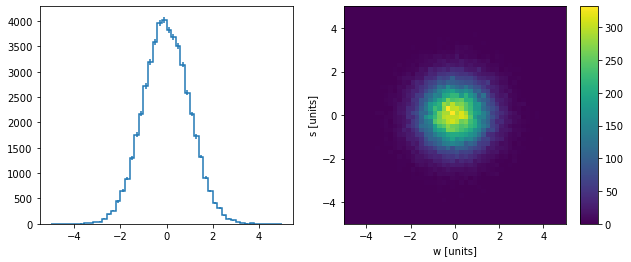

In [16]:
import matplotlib.pyplot as plt

# auto-plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

h.project("W").plot(ax=axs[0])
h.project("W", "S").plot(ax=axs[1])
plt.show()

This is an example of a pull plot:

In [17]:
from uncertainties import unumpy as unp


def pdf(x, a=1 / np.sqrt(2 * np.pi), x0=0, sigma=1, offset=0):
    exp = unp.exp if a.dtype == np.dtype("O") else np.exp
    return a * exp(-((x - x0) ** 2) / (2 * sigma ** 2)) + offset

*(The uncertainty is non-significant as we filled a great quantities of observation points above.)*

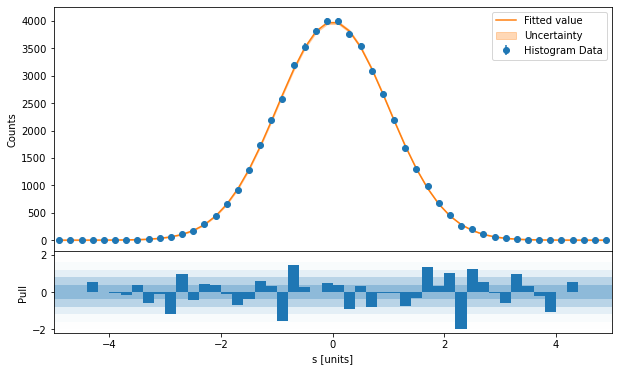

In [18]:
plt.figure(figsize=(10, 6))

h.project("S").plot_pull(pdf)

plt.show()

You can also pass Hist objects directly to mplhep (which is what is used for the backend of Hist anyway):

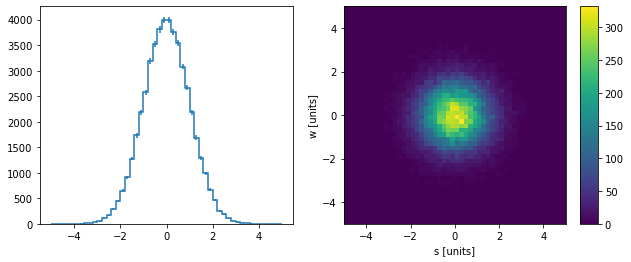

In [19]:
import mplhep

# auto-plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

mplhep.histplot(h.project("S"), ax=axs[0])
mplhep.hist2dplot(h, ax=axs[1])

plt.show()

## NamedHist

If you want to force names always be used, you can use NamedHist. This reduces functionality but can reduce mistaking one axes for another.

In [20]:
h = hist.NamedHist(
    hist.axis.Regular(
        50, -5, 5, name="S", label="s [units]", underflow=False, overflow=False
    ),
    hist.axis.Regular(
        50, -5, 5, name="W", label="w [units]", underflow=False, overflow=False
    ),
)

In [21]:
# should all use names
s_data = np.random.normal(size=50_000)
w_data = np.random.normal(size=50_000)

h.fill(W=w_data, S=s_data)

assert h[25, 25] == h[0j, 1j - 5] == h[{"W": 25, "S": 0j}]
assert h[:, 0:50:5j].project("S")

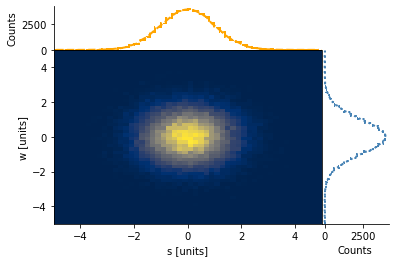

In [22]:
# plot2d full
h.plot2d_full(
    main_cmap="cividis",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)
plt.show()

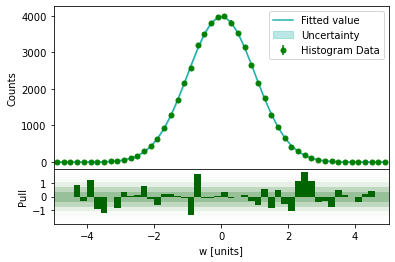

In [23]:
# plot pull
h.project("W").plot_pull(
    pdf,
    eb_ecolor="green",
    eb_mfc="green",
    eb_mec="green",
    eb_fmt="o",
    eb_ms=5,
    fp_color="lightseagreen",
    pp_color="darkgreen",
    pp_alpha=0.4,
    pp_ec=None,
    bar_color="darkgreen",
)
plt.show()